# NOTE TO SELF
When you come back try to evolve for a shorter time (say T=0.1) to see if higher order modes are better then

Add Schrodinger to loss fn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    print(f"CUDA available. Using device \"{torch.cuda.get_device_name()}\".")
else:
    print(f"CUDA not available.")

CUDA available. Using device "NVIDIA GeForce GTX 1650 with Max-Q Design".


In [2]:
### NUMERICAL SIMULATOR ###
import scipy.integrate
def numerical_schrodinger(initials, ts, grid_size=100, grid_length=1):

    psi0 = initials[0:2, :, :]    
    v = initials[2, :, :]
    shape = psi0.shape
    flattened_shape = np.prod(shape)
    
    # flatten
    psi0 = np.reshape(psi0, flattened_shape)
    
    # construct laplacian operator and then Hamiltonian
    dx = grid_length/grid_size
    D2 = -2*np.eye(grid_size)
    for i in range(grid_size-1):
        D2[i,i+1] = 1 
        D2[i+1,i] = 1
    
    KE = -0.5*D2/(dx**2)
 
    def dpsi_dt(t,y):        
        y = np.reshape(y, shape)
        psi_real = y[0]
        psi_imag = y[1]
        dpsi_real = np.expand_dims(-KE@psi_imag - v*psi_imag, 0)
        dpsi_imag = np.expand_dims(KE@psi_real + v*psi_real, 0)
        return np.reshape(np.concatenate((dpsi_real, dpsi_imag), axis=0), flattened_shape)
    
    #sol = scipy.integrate.odeint(dpsi_dt, psi0, ts)
    sol = scipy.integrate.solve_ivp(dpsi_dt, t_span=[0,np.max(ts)], y0=psi0, t_eval=ts, method="RK23")
    
    return np.reshape(sol.y, shape+(len(ts),))

In [3]:
### TRAINING DATA ###
from tqdm import tqdm
import scipy.interpolate

class SimpleFiniteStepDataset(torch.utils.data.Dataset):
    def __init__(self, grid_size=100, grid_length=1, fourier_modes=2, max_time=2.0, ntimes=50, num_initials=500):
        self.grid_size = grid_size
        self.grid_length = grid_length
        self.fourier_modes = fourier_modes
        self.max_time = max_time
        self.ntimes = ntimes
        self.num_data = num_initials*ntimes
        initials = np.empty((3, grid_size, num_initials))
        
        print('Generating Initials')
        for i in range(num_initials):
            psi0_real, psi0_imag, v = self._generate_initial()
            initials[0, :, i] = psi0_real.T
            initials[1, :, i] = psi0_imag.T
            initials[2, :, i] = v.T
        print('Finished generating initials.')
        
        ts = np.linspace(0, max_time, ntimes)
        integrated = numerical_schrodinger(initials, ts, grid_size, grid_length)
        
        self.data = []
        
        for i in range(self.num_data):
            a = i%self.ntimes
            b = int(i/self.ntimes)
            
            x_real = initials[0,:,b]
            x_imag = initials[1,:,b]
            x_potl = initials[2,:,b]
            
            x = np.concatenate((np.array([ts[a]]), x_real, x_imag, x_potl))
            
            y_real = integrated[0,:,b,a]
            y_imag = integrated[1,:,b,a]
            
            y = np.concatenate((y_real, y_imag))
            
            x = torch.tensor(x).float()
            y = torch.tensor(y).float()
            
            self.data.append([x,y])
        
    def __len__(self):
        return self.num_data
    
    def __getitem__(self, index):    
        return self.data[index]
                
    def _generate_initial(self):
        
        # create the initial wave function
        fourier_real_coefficients = 2*np.random.rand(self.fourier_modes)-1
        fourier_imag_coefficients = 2*np.random.rand(self.fourier_modes)-1
        n = np.arange(start=1, stop=self.fourier_modes+1, step=1)

        scale_factor = np.sum(fourier_real_coefficients**2) + np.sum(fourier_imag_coefficients**2)
        scale_factor = (2/(self.grid_length*scale_factor))**0.5
        fourier_real_coefficients *= scale_factor
        fourier_imag_coefficients *= scale_factor
        
        def init_wave_function(x):
            x = np.pi*x/self.grid_length
            psi_real = np.sin(np.outer(x, n))
            psi_real = psi_real*fourier_real_coefficients
            psi_real = np.sum(psi_real, axis=-1)
            
            psi_imag = np.sin(np.outer(x, n))
            psi_imag = psi_imag*fourier_imag_coefficients
            psi_imag = np.sum(psi_imag, axis=-1)
            
            return psi_real, psi_imag
        
        
        # TODO: change when we have a better potential
        potential_function = lambda x: 0*x
        
        x = np.linspace(0, self.grid_length, self.grid_size)
        psi_real, psi_imag = init_wave_function(x)
        v = potential_function(x)
        
        return psi_real, psi_imag, v
        
    

In [4]:
# Generate training data
import time

print('Generating data...')
start = time.perf_counter()
data = SimpleFiniteStepDataset(grid_size=100, grid_length=1, fourier_modes=1, max_time=0.5, ntimes=50, num_initials=200)
end = time.perf_counter()
print(f'Training data generated after {end-start} seconds!')

Generating data...
Generating Initials
Finished generating initials.
Training data generated after 26.089604604000215 seconds!


In [5]:
### MODEL DEFN ###
class SimpleFiniteStepSolver(nn.Module):
    def __init__(self, grid_size=100, hidden_dim=20):
        super(SimpleFiniteStepSolver, self).__init__()
        
        self.grid_size = grid_size

        self.mlp = nn.Sequential(
            nn.Linear(3*grid_size+1, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 2*grid_size)
        )

    def forward(self, x):
        return self.mlp(x)

In [6]:
# Try to train
from tqdm import tqdm
import matplotlib.pyplot as plt # DEBUG TMP

nepochs = 100
model = SimpleFiniteStepSolver(grid_size=100, hidden_dim=300).to(device)

train_data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

optm = torch.optim.Adam(model.parameters(), lr = 0.001)

mse_hyperparam = 1
norm_hyperparam = 0
schrod_hyperparam = 0

def norm_factor(output):
    norm = torch.sum(output**2)* data.grid_length / (np.prod(output.shape) / 2)
    norm_factor = (norm-1)**2
    return norm_factor

grid_size = model.grid_size
def schrodinger_loss(output, in_put):
    batch_size = output.shape[0]
    
    psi_real = output[:,:grid_size]
    psi_imag = output[:,grid_size:]
    
    # Calculate Laplacian
    zero = torch.zeros((output.shape[0], 1)).to(device)
    psi_real_exp = torch.cat((zero, psi_real, zero), dim=1)
    psi_imag_exp = torch.cat((zero, psi_imag, zero), dim=1)
    
    dx = data.grid_length / grid_size
    d2_psi_real = (psi_real_exp[:,0:-2] + psi_real_exp[:,2:] - 2*psi_real_exp[:,1:-1]) / dx**2
    d2_psi_imag = (psi_imag_exp[:,0:-2] + psi_imag_exp[:,2:] - 2*psi_imag_exp[:,1:-1]) / dx**2
    
    # Calculate time derivative
    t = torch.zeros((batch_size,301)).to(device)
    t[:,0] = 1
    
    psi_dt = torch.autograd.functional.jvp(model, in_put, v=t, create_graph=True)[1]
    psi_dt_real = psi_dt[:,:grid_size]
    psi_dt_imag = psi_dt[:,grid_size:]
    
    # Calculate potential energy
    V = in_put[:,2*grid_size+1:]
    V_real = V * psi_real
    V_imag = V * psi_imag
    
    # DEBUG
#     plt.figure()
#     xs = np.linspace(0,1,grid_size)
#     plt.plot(xs,psi_dt_real.detach().cpu().numpy()[0,:])
#     plt.plot(xs, (-0.5*d2_psi_imag + V_imag).detach().cpu().numpy()[0,:])
#     plt.show()
    
    # Calculate loss
    diff_1 = psi_dt_real + 0.5*d2_psi_imag - V_imag
    diff_2 = psi_dt_imag - 0.5*d2_psi_real + V_real
    
#     print(diff_1)
#     print(diff_2)
    
    return torch.sum(diff_1**2 + diff_2**2)/grid_size 


def custom_loss(output, in_put, target):
    mse =  F.mse_loss(output,y)
    n_factor = norm_factor(output)
    schrod_loss = schrodinger_loss(output, in_put)
    
    return mse + norm_hyperparam*n_factor + schrod_hyperparam*schrod_loss
    

for epoch in range(nepochs):
    epoch_loss = 0
    
    for x,y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)
        
        optm.zero_grad()
        output = model(x)
        #loss = F.mse_loss(output,y)        
        loss = custom_loss(output,x,y)
        
        loss.backward()
        optm.step()
        
        epoch_loss+=loss/len(train_data_loader)
        
    print('Epoch {} Loss : {:.3e}'.format((epoch+1),epoch_loss))

100%|██████████| 100/100 [00:01<00:00, 59.07it/s]


Epoch 1 Loss : 2.295e-01


100%|██████████| 100/100 [00:01<00:00, 61.54it/s]


Epoch 2 Loss : 1.949e-01


100%|██████████| 100/100 [00:01<00:00, 61.58it/s]


Epoch 3 Loss : 9.187e-02


100%|██████████| 100/100 [00:01<00:00, 64.99it/s]


Epoch 4 Loss : 1.120e-02


100%|██████████| 100/100 [00:01<00:00, 62.19it/s]


Epoch 5 Loss : 4.534e-03


100%|██████████| 100/100 [00:01<00:00, 74.99it/s]


Epoch 6 Loss : 2.810e-03


100%|██████████| 100/100 [00:01<00:00, 87.20it/s]


Epoch 7 Loss : 1.549e-03


100%|██████████| 100/100 [00:01<00:00, 75.22it/s]


Epoch 8 Loss : 1.350e-03


100%|██████████| 100/100 [00:01<00:00, 77.01it/s]


Epoch 9 Loss : 9.938e-04


100%|██████████| 100/100 [00:01<00:00, 76.37it/s]


Epoch 10 Loss : 1.592e-03


100%|██████████| 100/100 [00:01<00:00, 78.37it/s]


Epoch 11 Loss : 8.393e-04


100%|██████████| 100/100 [00:01<00:00, 82.06it/s]


Epoch 12 Loss : 2.259e-03


100%|██████████| 100/100 [00:01<00:00, 82.32it/s]


Epoch 13 Loss : 4.629e-04


100%|██████████| 100/100 [00:01<00:00, 81.07it/s]


Epoch 14 Loss : 8.231e-04


100%|██████████| 100/100 [00:01<00:00, 80.93it/s]


Epoch 15 Loss : 5.514e-04


100%|██████████| 100/100 [00:01<00:00, 82.84it/s]


Epoch 16 Loss : 3.693e-03


100%|██████████| 100/100 [00:01<00:00, 81.25it/s]


Epoch 17 Loss : 3.774e-03


100%|██████████| 100/100 [00:01<00:00, 69.81it/s]


Epoch 18 Loss : 6.304e-04


100%|██████████| 100/100 [00:01<00:00, 63.01it/s]


Epoch 19 Loss : 3.242e-04


100%|██████████| 100/100 [00:01<00:00, 62.65it/s]


Epoch 20 Loss : 3.035e-04


100%|██████████| 100/100 [00:01<00:00, 67.30it/s]


Epoch 21 Loss : 3.393e-04


100%|██████████| 100/100 [00:01<00:00, 65.89it/s]


Epoch 22 Loss : 4.779e-04


100%|██████████| 100/100 [00:01<00:00, 70.03it/s]


Epoch 23 Loss : 3.016e-03


100%|██████████| 100/100 [00:01<00:00, 61.19it/s]


Epoch 24 Loss : 1.491e-03


100%|██████████| 100/100 [00:01<00:00, 68.34it/s]


Epoch 25 Loss : 5.047e-04


100%|██████████| 100/100 [00:01<00:00, 59.67it/s]


Epoch 26 Loss : 3.294e-04


100%|██████████| 100/100 [00:01<00:00, 57.88it/s]


Epoch 27 Loss : 3.466e-04


100%|██████████| 100/100 [00:01<00:00, 66.48it/s]


Epoch 28 Loss : 3.833e-04


100%|██████████| 100/100 [00:01<00:00, 60.33it/s]


Epoch 29 Loss : 1.667e-03


100%|██████████| 100/100 [00:01<00:00, 51.11it/s]


Epoch 30 Loss : 1.283e-03


100%|██████████| 100/100 [00:01<00:00, 52.35it/s]


Epoch 31 Loss : 4.096e-04


100%|██████████| 100/100 [00:01<00:00, 61.24it/s]


Epoch 32 Loss : 8.394e-04


100%|██████████| 100/100 [00:01<00:00, 76.76it/s]


Epoch 33 Loss : 8.897e-04


100%|██████████| 100/100 [00:01<00:00, 59.75it/s]


Epoch 34 Loss : 1.484e-03


100%|██████████| 100/100 [00:01<00:00, 58.21it/s]


Epoch 35 Loss : 3.698e-04


100%|██████████| 100/100 [00:01<00:00, 51.64it/s]


Epoch 36 Loss : 1.694e-03


100%|██████████| 100/100 [00:01<00:00, 58.26it/s]


Epoch 37 Loss : 8.784e-04


100%|██████████| 100/100 [00:01<00:00, 56.90it/s]


Epoch 38 Loss : 3.167e-04


100%|██████████| 100/100 [00:01<00:00, 56.89it/s]


Epoch 39 Loss : 4.351e-04


100%|██████████| 100/100 [00:01<00:00, 58.25it/s]


Epoch 40 Loss : 2.303e-03


100%|██████████| 100/100 [00:01<00:00, 61.49it/s]


Epoch 41 Loss : 1.348e-03


100%|██████████| 100/100 [00:01<00:00, 57.63it/s]


Epoch 42 Loss : 6.198e-04


100%|██████████| 100/100 [00:01<00:00, 57.73it/s]


Epoch 43 Loss : 3.560e-04


100%|██████████| 100/100 [00:01<00:00, 56.37it/s]


Epoch 44 Loss : 3.650e-04


100%|██████████| 100/100 [00:01<00:00, 60.67it/s]


Epoch 45 Loss : 8.236e-04


100%|██████████| 100/100 [00:01<00:00, 63.45it/s]


Epoch 46 Loss : 3.932e-04


100%|██████████| 100/100 [00:01<00:00, 56.55it/s]


Epoch 47 Loss : 1.911e-03


100%|██████████| 100/100 [00:01<00:00, 56.51it/s]


Epoch 48 Loss : 7.314e-04


100%|██████████| 100/100 [00:01<00:00, 55.06it/s]


Epoch 49 Loss : 4.818e-04


100%|██████████| 100/100 [00:01<00:00, 57.55it/s]


Epoch 50 Loss : 4.212e-04


100%|██████████| 100/100 [00:01<00:00, 56.91it/s]


Epoch 51 Loss : 7.921e-04


100%|██████████| 100/100 [00:01<00:00, 52.38it/s]


Epoch 52 Loss : 1.965e-03


100%|██████████| 100/100 [00:01<00:00, 57.37it/s]


Epoch 53 Loss : 3.954e-04


100%|██████████| 100/100 [00:01<00:00, 57.47it/s]


Epoch 54 Loss : 3.207e-04


100%|██████████| 100/100 [00:01<00:00, 62.30it/s]


Epoch 55 Loss : 3.481e-04


100%|██████████| 100/100 [00:01<00:00, 55.53it/s]


Epoch 56 Loss : 5.944e-04


100%|██████████| 100/100 [00:01<00:00, 58.87it/s]


Epoch 57 Loss : 4.280e-03


100%|██████████| 100/100 [00:01<00:00, 58.00it/s]


Epoch 58 Loss : 4.122e-04


100%|██████████| 100/100 [00:01<00:00, 76.36it/s]


Epoch 59 Loss : 2.939e-04


100%|██████████| 100/100 [00:01<00:00, 66.54it/s]


Epoch 60 Loss : 3.079e-04


100%|██████████| 100/100 [00:01<00:00, 78.08it/s]


Epoch 61 Loss : 3.744e-04


100%|██████████| 100/100 [00:01<00:00, 79.65it/s]


Epoch 62 Loss : 2.162e-03


100%|██████████| 100/100 [00:01<00:00, 82.74it/s]


Epoch 63 Loss : 8.509e-04


100%|██████████| 100/100 [00:01<00:00, 92.45it/s]


Epoch 64 Loss : 5.285e-04


100%|██████████| 100/100 [00:01<00:00, 77.69it/s]


Epoch 65 Loss : 6.856e-04


100%|██████████| 100/100 [00:01<00:00, 85.82it/s]


Epoch 66 Loss : 3.782e-04


100%|██████████| 100/100 [00:01<00:00, 87.72it/s]


Epoch 67 Loss : 4.267e-04


100%|██████████| 100/100 [00:01<00:00, 87.77it/s]


Epoch 68 Loss : 3.061e-04


100%|██████████| 100/100 [00:01<00:00, 83.43it/s]


Epoch 69 Loss : 5.445e-04


100%|██████████| 100/100 [00:01<00:00, 73.21it/s]


Epoch 70 Loss : 1.569e-03


100%|██████████| 100/100 [00:01<00:00, 85.78it/s]


Epoch 71 Loss : 3.950e-03


100%|██████████| 100/100 [00:01<00:00, 80.84it/s]


Epoch 72 Loss : 5.532e-04


100%|██████████| 100/100 [00:01<00:00, 92.17it/s]


Epoch 73 Loss : 2.190e-04


100%|██████████| 100/100 [00:01<00:00, 85.15it/s]


Epoch 74 Loss : 2.178e-04


100%|██████████| 100/100 [00:01<00:00, 72.67it/s]


Epoch 75 Loss : 2.401e-04


100%|██████████| 100/100 [00:01<00:00, 81.47it/s]


Epoch 76 Loss : 2.881e-04


100%|██████████| 100/100 [00:01<00:00, 86.51it/s]


Epoch 77 Loss : 3.226e-04


100%|██████████| 100/100 [00:01<00:00, 88.22it/s]


Epoch 78 Loss : 5.687e-04


100%|██████████| 100/100 [00:01<00:00, 75.84it/s]


Epoch 79 Loss : 1.238e-03


100%|██████████| 100/100 [00:01<00:00, 82.70it/s]


Epoch 80 Loss : 1.341e-03


100%|██████████| 100/100 [00:01<00:00, 73.07it/s]


Epoch 81 Loss : 3.359e-04


100%|██████████| 100/100 [00:01<00:00, 79.61it/s]


Epoch 82 Loss : 3.741e-04


100%|██████████| 100/100 [00:01<00:00, 68.86it/s]


Epoch 83 Loss : 2.957e-04


100%|██████████| 100/100 [00:01<00:00, 57.80it/s]


Epoch 84 Loss : 3.153e-04


100%|██████████| 100/100 [00:01<00:00, 58.97it/s]


Epoch 85 Loss : 1.181e-03


100%|██████████| 100/100 [00:01<00:00, 61.55it/s]


Epoch 86 Loss : 7.233e-04


100%|██████████| 100/100 [00:01<00:00, 58.35it/s]


Epoch 87 Loss : 4.993e-04


100%|██████████| 100/100 [00:01<00:00, 51.93it/s]


Epoch 88 Loss : 2.430e-04


100%|██████████| 100/100 [00:01<00:00, 59.71it/s]


Epoch 89 Loss : 3.917e-04


100%|██████████| 100/100 [00:01<00:00, 67.38it/s]


Epoch 90 Loss : 5.025e-04


100%|██████████| 100/100 [00:01<00:00, 63.31it/s]


Epoch 91 Loss : 1.224e-03


100%|██████████| 100/100 [00:01<00:00, 62.77it/s]


Epoch 92 Loss : 9.245e-04


100%|██████████| 100/100 [00:01<00:00, 61.45it/s]


Epoch 93 Loss : 2.845e-04


100%|██████████| 100/100 [00:01<00:00, 65.40it/s]


Epoch 94 Loss : 2.263e-04


100%|██████████| 100/100 [00:01<00:00, 66.39it/s]


Epoch 95 Loss : 1.573e-03


100%|██████████| 100/100 [00:01<00:00, 60.13it/s]


Epoch 96 Loss : 1.184e-03


100%|██████████| 100/100 [00:01<00:00, 59.92it/s]


Epoch 97 Loss : 2.749e-04


100%|██████████| 100/100 [00:01<00:00, 60.26it/s]


Epoch 98 Loss : 2.055e-04


100%|██████████| 100/100 [00:01<00:00, 59.73it/s]


Epoch 99 Loss : 3.027e-04


100%|██████████| 100/100 [00:01<00:00, 56.54it/s]

Epoch 100 Loss : 2.399e-04


In [7]:
dt = 0.01
T = 0.5
ts = np.arange(0,T,dt)

grid_length = 1
grid_size = model.grid_size

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def solve_single_numerically(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs_num = np.linspace(0,grid_length,grid_size)
    p0_real, p0_imag = psi0(xs_num)
    vs = v(xs_num)
    
    initials = np.zeros((3, grid_size, 1))
    initials[0, :, 0] = p0_real.T
    initials[1, :, 0] = p0_imag.T
    initials[2, :, 0] = vs.T
    
    num_y = numerical_schrodinger(initials, ts, grid_size=grid_size)
    
    num_ys_real = num_y[0,:,0,:]
    num_ys_imag = num_y[1,:,0,:]
    
    return num_ys_real.T, num_ys_imag.T


def solve_single_nn(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs = torch.linspace(0, grid_length, grid_size)
    p0_real, p0_imag = psi0(xs)
    vs = v(xs)
    
    if not torch.is_tensor(ts):
        ts = torch.tensor(ts)
    
    nn_in = torch.zeros((len(ts), 3*grid_size + 1))
    nn_in[:,0] = ts
    nn_in[:,1:] = torch.cat((p0_real, p0_imag, vs))
    nn_in = nn_in.to(device)
    
    nn_out = model(nn_in).cpu().detach().numpy()
    
    out_real = nn_out[:,:grid_size]
    out_imag = nn_out[:,grid_size:]
    
    return out_real, out_imag
    

def test_model(psi0, v, plot_phase=False):
    # Solve numerically
    print('Solving numerically...')
    num_ys_real,num_ys_imag = solve_single_numerically(psi0, v, ts, grid_size, grid_length)
    print('Finished solving numerically.')
   
    # Solve using our method
    print('Solving nn...')
    nn_ys_real, nn_ys_imag = solve_single_nn(psi0, v, ts, grid_size, grid_length)
    print('Finished solving nn.')
    
    xs = np.linspace(0, grid_length, grid_size)
    
    # Normalisation vs time
    fig = plt.figure(figsize=(5,5))
    plt.plot(ts, np.sum(nn_ys_real**2 + nn_ys_imag**2, axis=1)*grid_length / grid_size)
    fig.suptitle('Normalisation')
    plt.xlabel('Time')
    plt.ylabel('∫|Ψ|² dx')
    
    # Plot animations
    fig = plt.figure(figsize=(12,8))
    
    plt.rcParams["animation.html"] = "html5"
    plt.rcParams["figure.dpi"] = 75
    
    # Helper for setting up subplot limits and labels
    def setup_subplot(subplot, prop):
        prop = prop.upper()
        if not prop in ["REAL", "IMAG", "ABS", "PHASE"]:
            raise ValueError(f'Bad property \'{prop}\'.')
        subplot.set_xlim(0,grid_length)
        if prop in ["REAL", "IMAG"]:
            subplot.set_ylim(-2,2)
            subplot.set_ylabel("Real" if prop == "REAL" else "Imaginary")
        if prop == "ABS":
            subplot.set_ylim(0,2)
            subplot.set_ylabel("Magnitude")
        if prop == "PHASE":
            subplot.set_ylim(-np.pi,np.pi)
            subplot.set_ylabel("Phase")
            subplot.set_yticks(np.arange(-np.pi,np.pi,np.pi/4))
        
        line, = subplot.plot([],[], lw=2)
        return line
    
    # Types of each subplot
    props = [None]*4
    if plot_phase:
        props = ["ABS", "ABS", "PHASE", "PHASE"]
    else:
        props = ["REAL", "REAL", "IMAG", "IMAG"]
       
    subplots = [None]*4
    lines = [None]*4
    for i in range(4):
        subplots[i] = plt.subplot(2,2,i+1)
        lines[i] = setup_subplot(subplots[i], props[i])
        
    subplots[0].title.set_text('NN model')
    subplots[1].title.set_text('Numerical model')
    
    def animate(i):
        if plot_phase:
            lines[0].set_data(xs, np.sqrt(nn_ys_real[i,:]**2 + nn_ys_imag[i,:]**2))
            lines[2].set_data(xs, np.arctan2(nn_ys_real[i,:], nn_ys_imag[i,:]))
        
            lines[1].set_data(xs, np.sqrt(num_ys_real[i,:]**2 + num_ys_imag[i,:]**2))
            lines[3].set_data(xs, np.arctan2(num_ys_real[i,:], num_ys_imag[i,:]))

        else:
            lines[0].set_data(xs, nn_ys_real[i,:])
            lines[2].set_data(xs, nn_ys_imag[i,:])
            
            lines[1].set_data(xs, num_ys_real[i,:])
            lines[3].set_data(xs, num_ys_imag[i,:])

        return lines
    
    anim = animation.FuncAnimation(fig, animate, frames=len(ts), interval=50, blit=True)
    HTML(anim.to_html5_video())
    return anim

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


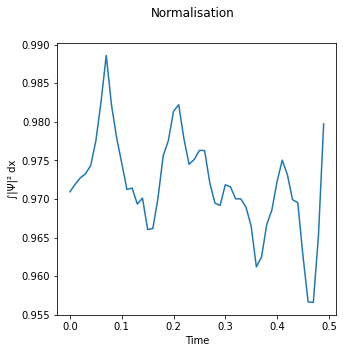

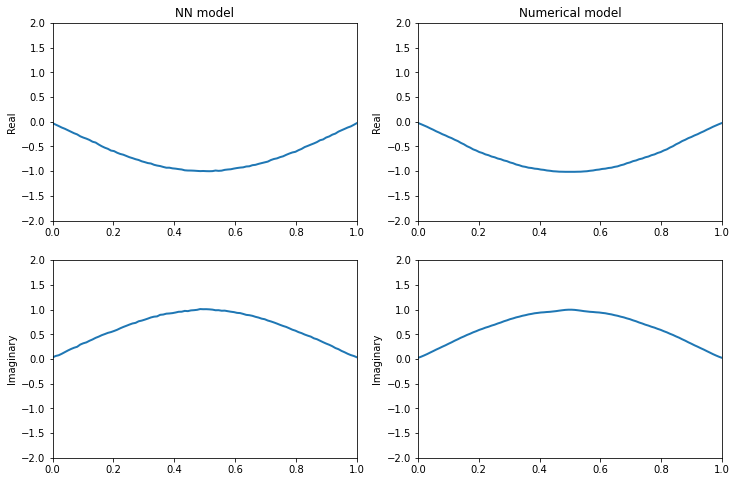

In [8]:
# Particle in a Box Ground State - Real+Imag

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


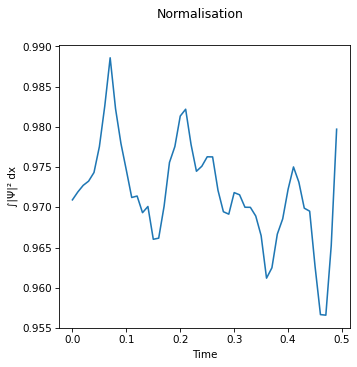

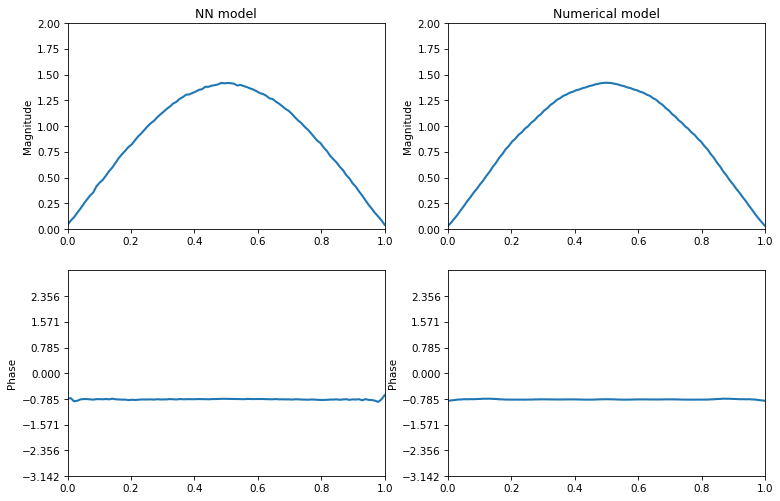

In [9]:
# Particle in a Box Ground State - Amplitude+Phase

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=True)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


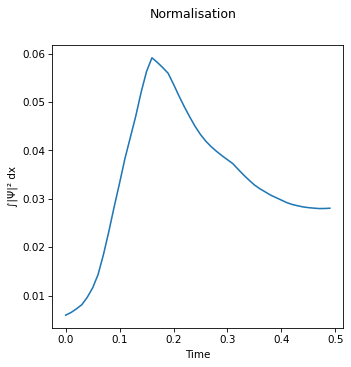

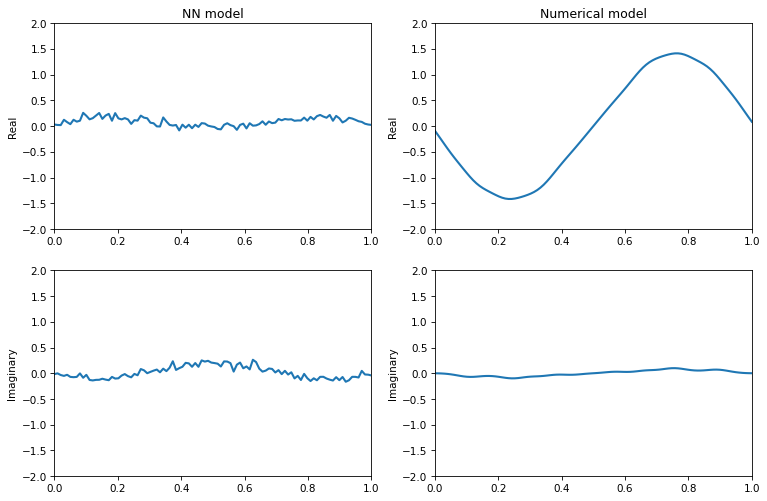

In [10]:
# Particle in a Box - First Excited State

def psi0(x):
    real = np.sqrt(2)*np.sin(2*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

In [11]:
import random
import matplotlib.pyplot as plt
def check_training_data(d,n=10):
    subset = random.sample(d,n)
    
    for s in subset:
        grid_size = int((len(s[0])-1)/3)
                
        init_real = s[0][1:grid_size+1]
        init_imag = s[0][grid_size+1:2*grid_size+1]
        
        final_real = s[1][:grid_size]
        final_imag = s[1][grid_size:]
        
        xs = np.linspace(0,1,grid_size)
                
        plt.figure()
        sbp1 = plt.subplot(2,2,1)
        sbp1.title.set_text('t=0')
        sbp1.set_xlim(0,1)
        sbp1.set_ylim(0,2)
        l1, = sbp1.plot(xs,np.sqrt(init_real**2 + init_imag**2), lw=2)

        sbp3 = plt.subplot(2,2,3)
        sbp3.set_xlim(0,1)
        sbp3.set_ylim(-1*np.pi,np.pi)
        l3, = sbp3.plot(xs,np.arctan2(init_real,init_imag), lw=2)

        sbp2 = plt.subplot(2,2,2)
        sbp2.title.set_text(f't={s[0][0]}')
        sbp2.set_xlim(0,1)
        sbp2.set_ylim(0,2)
        l2, = sbp2.plot(xs,np.sqrt(final_real**2 + final_imag**2), lw=2)

        sbp4 = plt.subplot(2,2,4)
        sbp4.set_xlim(0,1)
        sbp4.set_ylim(-1*np.pi,np.pi)
        l4, = sbp4.plot(xs, np.arctan2(final_real, final_imag), lw=2)
        

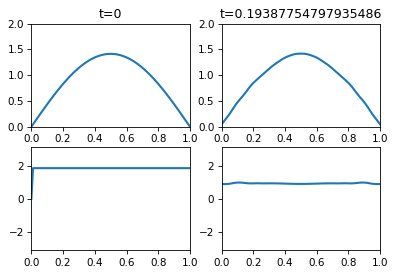

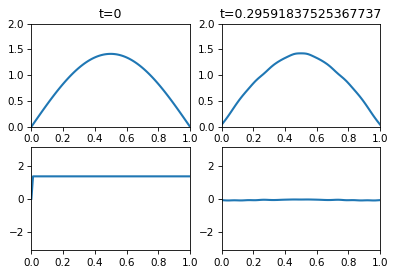

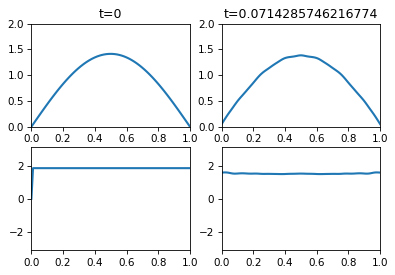

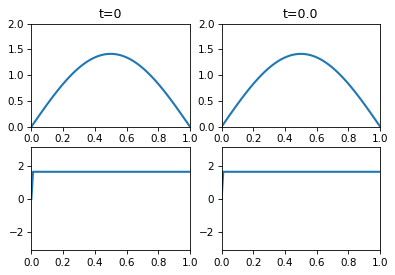

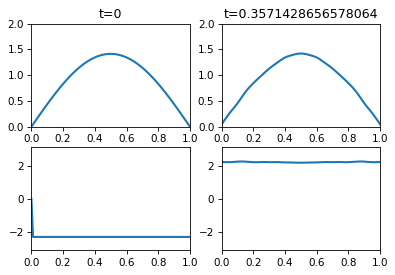

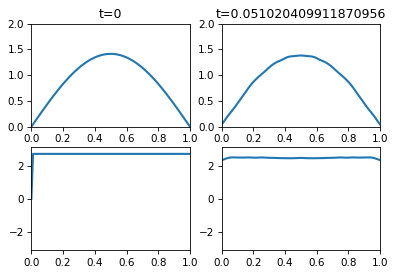

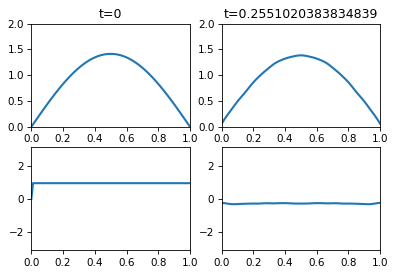

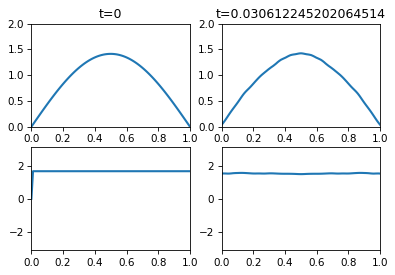

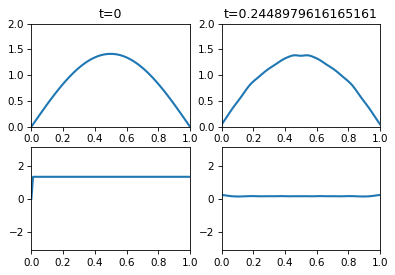

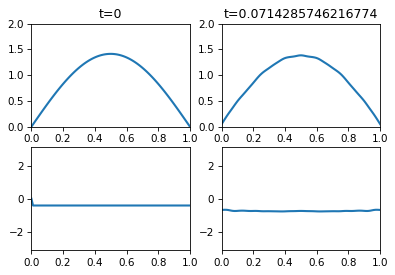

In [12]:
check_training_data(data.data)

  0%|          | 0/100 [00:00<?, ?it/s]

(100,)
(100, 100)
torch.Size([100, 200])


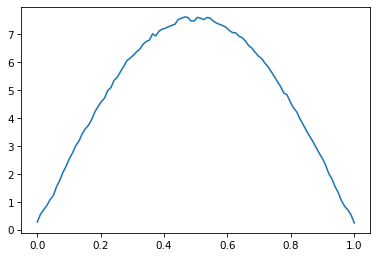

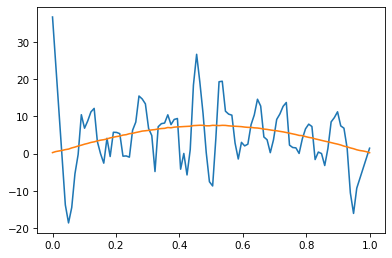

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [101]:
# TEST FOR DEBUG

# Try to train
from tqdm import tqdm
import matplotlib.pyplot as plt # DEBUG TMP
import scipy.interpolate

nepochs = 100

train_data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)


mse_hyperparam = 1
norm_hyperparam = 0
schrod_hyperparam = 0

def norm_factor(output):
    norm = torch.sum(output**2)* data.grid_length / (np.prod(output.shape) / 2)
    norm_factor = (norm-1)**2
    return norm_factor

grid_size = model.grid_size
def schrodinger_loss(output, in_put):
    batch_size = output.shape[0]
    
    psi_real = output[:,:grid_size]
    psi_imag = output[:,grid_size:]
    
    # Calculate Laplacian
    xs = np.linspace(0,1,grid_size)
    psi_real_np = psi_real.detach().cpu().numpy()
    psi_imag_np = psi_imag.detach().cpu().numpy()
    
    print(xs.shape)
    print(psi_real_np.shape)
    
    d2_psi_real = scipy.signal.savgol_filter(psi_real_np,9,3,deriv=2, delta=1/100, axis=1)
    d2_psi_imag = scipy.signal.savgol_filter(psi_imag_np,9,3,deriv=2, delta=1/100, axis=1)
    
#     zero = torch.zeros((output.shape[0], 1)).to(device)
#     psi_real_exp = torch.cat((zero, psi_real, zero), dim=1)
#     psi_imag_exp = torch.cat((zero, psi_imag, zero), dim=1)
    
#     dx = data.grid_length / grid_size
#     d2_psi_real = (psi_real_exp[:,0:-2] + psi_real_exp[:,2:] - 2*psi_real_exp[:,1:-1]) / dx**2
#     d2_psi_imag = (psi_imag_exp[:,0:-2] + psi_imag_exp[:,2:] - 2*psi_imag_exp[:,1:-1]) / dx**2
    
    # Calculate time derivative
    t = torch.zeros((batch_size,301)).to(device)
    t[:,0] = 1
    
    psi_dt = torch.autograd.functional.jvp(model, in_put, v=t, create_graph=True)[1]
    print(psi_dt.shape)
    psi_dt_real = psi_dt[:,:grid_size]
    psi_dt_imag = psi_dt[:,grid_size:]
    
    # Calculate potential energy
    V = in_put[:,2*grid_size+1:]
    V_real = V * psi_real
    V_imag = V * psi_imag
    
    # DEBUG
    plt.figure()
    xs = np.linspace(0,1,grid_size)
    
    # Plot time derivative
    
#     dpt_1 = psi_dt_real.detach().cpu().numpy()[0,:]
#     dpt_2 = psi_dt_imag.detach().cpu().numpy()[0,:]
    
#     plt.plot(xs,np.sqrt(dpt_1**2 + dpt_1**2))
#     plt.show()
    
    px_1 = (-d2_psi_real)[0,:]
    px_2 = np.pi**2 * psi_real[0,:].detach().cpu().numpy()
    
    # Plot original wavefn
    plt.plot(xs, px_2)
    #plt.plot(xs,scipy.signal.savgol_filter(px_2,13,3), lw=1.25)
    plt.show()
    
    # Plot second dervative against original wavefn
    plt.plot(xs,px_1)
    plt.plot(xs,px_2)
    plt.show()


def custom_loss(output, in_put, target):
    mse =  F.mse_loss(output,y)
    n_factor = norm_factor(output)
    schrod_loss = schrodinger_loss(output, in_put)
    
    return mse + norm_hyperparam*n_factor + schrod_hyperparam*schrod_loss
    

for epoch in range(nepochs):
    epoch_loss = 0
    
    for x,y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)      
        loss = custom_loss(output,x,y)

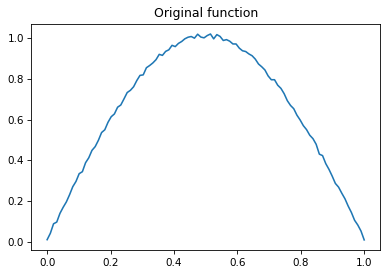

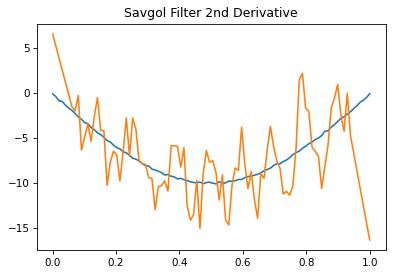

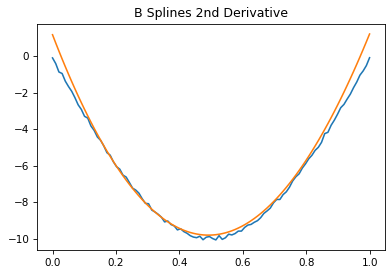

In [135]:
# Test of B-spline and savgol smoothing and differentiation

import scipy.interpolate
import scipy.signal

n = 1

xs = np.linspace(0,1,100)
ys = np.sin(n*np.pi*xs) + np.random.rand(100)*0.025

ys_smooth = scipy.signal.savgol_filter(ys,13,3,deriv=0)
savgol_d2ydx2 = scipy.signal.savgol_filter(ys,13,3,deriv=2, delta=1/100)

tck = scipy.interpolate.splrep(xs,ys, k=5, s=0.01, task=0)
tck2 = scipy.interpolate.splder(tck,2)
bsplines_d2ydx2 = scipy.interpolate.splev(xs,tck2)


# plt.plot(xs,ys)
# plt.show()

plt.plot(xs,ys)
plt.title('Original function')
plt.show()

plt.plot(xs, -1*n**2*np.pi**2 * ys)
plt.plot(xs,savgol_d2ydx2)
plt.title('Savgol Filter 2nd Derivative')
plt.show()

plt.plot(xs, -1*n**2*np.pi**2 * ys)
plt.plot(xs,bsplines_d2ydx2)
plt.title('B Splines 2nd Derivative')
plt.show()
